# First Assignment: Predicting employee attrition

#### Participants
<br>
Paula Marcela Mora Caballero (100483694)
<br>
Piero Rivera Ramírez (100435291)
<br>


## Requirements

### Packages

In [4]:
!pip install scikit_optimize
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from time import time 
from joblib import dump, load

# sklearn
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from statsmodels.stats.proportion import proportion_confint
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn import set_config
set_config(display="diagram")

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from skopt.plots import plot_objective
from skopt.plots import plot_evaluations

from scipy.stats import uniform, expon
from scipy.stats import randint as sp_randint

# optuna
import optuna

from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

# deprecation warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Steps to follow:


### 1. Explonatory Data Analysis 

**Load of datasets**

In [7]:
# Load of datasets
# Comment / Uncomment shortcut: Ctrl + /

# Google Drive (Marcela)
df_av = pd.read_pickle('/content/drive/MyDrive/Big Data Intelligence (Assignments)/attrition_available_32.pkl')
df_co = pd.read_pickle('/content/drive/MyDrive/Big Data Intelligence (Assignments)/attrition_compet_32.pkl')

# Jupyter (Piero)
#df_av = pd.read_pickle('../Datasets/attrition_available_32.pkl')
#df_co = pd.read_pickle('../Datasets/attrition_compet_32.pkl')

By displaying the first records and the column names of one of the datasets we can get an initial idea of the information it has.

In [8]:
df_av.head(5)

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,7.315971,13,2,4,3.0,2.0,4.0,31,Yes,Travel_Frequently,...,0.0,Y,23,8,1,6.0,3,5,1,4
6,6.450877,17,3,4,1.0,3.0,1.0,28,Yes,Travel_Rarely,...,2.0,Y,20,8,1,5.0,2,0,0,0
13,8.871421,14,2,3,1.0,2.0,2.0,47,Yes,Non-Travel,...,1.0,Y,11,8,2,10.0,4,10,9,9
28,10.713066,6,2,3,4.0,3.0,1.0,44,Yes,Travel_Frequently,...,3.0,Y,14,8,1,19.0,2,1,0,0
30,9.662808,11,2,3,1.0,2.0,3.0,26,Yes,Travel_Rarely,...,2.0,Y,11,8,0,5.0,5,3,0,2


**Features and Instances**

In the employee attrition datasets we have 30 features that will help predict whether or not an employee leaves the company. The additional column in the *available* dataset is the target variable: Attration, which is a categorial feature: Yes/No.

In [9]:
print(f'The available dataset has: {df_av.shape[0]} instances and {df_av.shape[1]} features')
print(f'The competition dataset has: {df_co.shape[0]} instances and {df_co.shape[1]} features')

The available dataset has: 1426 instances and 31 features
The competition dataset has: 200 instances and 30 features


**Type of features**

After confirming that both datasets' column types are the same, we will only describe each column's type for the *available* dataset.

In [10]:
print(f'In the dataset, there are three types of columns. There are {df_av.dtypes.value_counts()[0]} integer columns, {df_av.dtypes.value_counts()[1]} object columns and {df_av.dtypes.value_counts()[2]} float64 columns.')
print('')
print('Type of columns in dataset:')
df_av.dtypes
#df_co.dtypes # same types than in df_av - available dataset

In the dataset, there are three types of columns. There are 16 integer columns, 8 object columns and 7 float64 columns.

Type of columns in dataset:


hrs                        float64
absences                     int64
JobInvolvement               int64
PerformanceRating            int64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                          int64
Attrition                   object
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                  float64
EducationField              object
EmployeeCount                int64
EmployeeID                   int64
Gender                      object
JobLevel                     int64
JobRole                     object
MaritalStatus               object
MonthlyIncome                int64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike            int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany      

After a column-by-column inspection of the information contained in each column. 

We consider that there are 23 numerical variables:
1.   hrs
2.   absences
3.   age
4.   DistanceFromHome
5.   EmployeeCount
6.   MonthlyIncome
7.   NumCompaniesWorked
8.   PercentSalaryHike
9.   StandardHours
10.  TotalWorkingYears
11.  TrainingTimesLastYear
12.  YearsAtCompany
13.  YearsSinceLastPromotion
14.  YearsWithCurrManager
15.  EmployeeID (ID variable)

Ordinal variables:
16.   JobInvolvement (Values: 1, 2, 3 and 4)
17.   PerformanceRating (Values: 3 and 4)
18.   EnvironmentSatisfaction (Values: 1, 2, 3 and 4)
19.   JobSatisfaction (Values: 1, 2, 3 and 4)
20.   WorkLifeBalance (Values: 1, 2, 3 and 4)
21.   Education (Values: 1, 2, 3, 4 and 5)
22.  JobLevel (Values: 1, 2, 3, 4 and 5)
23.  StockOptionLevel (Values: 0, 1, 2 and 3)

And 8 categorical variables:
1.   Attrition (Target variable)
2.   BusinessTravel 
3.   Department 
4.  EducationField 
5.  Gender 
6.  JobRole 
7.  MaritalStatus 
8.  Over18

**Cardinality of categorical variables**

We checked the cardinality of the categorical variables for both datasets. Most of the categorical variables have low cardinality (1, 2 or 3 categories). The highest cardinality variables are EducationField and JobRole (7 and 9 categories respectively).

In [11]:
categorial_variables = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18']

print('Available dataset:')        
for col in df_av[categorial_variables]:
    print(f'{col}: {len(df_av[col].unique())}')

print('')
print('Competition dataset:')        
for col in df_co[categorial_variables]:
    print(f'{col}: {len(df_co[col].unique())}')

Available dataset:
BusinessTravel: 3
Department: 3
EducationField: 7
Gender: 2
JobRole: 9
MaritalStatus: 3
Over18: 1

Competition dataset:
BusinessTravel: 3
Department: 3
EducationField: 7
Gender: 2
JobRole: 9
MaritalStatus: 3
Over18: 1


**ID variable: EmployeeID**

Based on the name of this variable, it seems to be an ID, then each instance should have a distinct value (that would be 1426 different values). The EmployeeID has 1368 unique values, so we investigated about this in both datasets.

We checked that on one hand, in the *available* dataset, there are 54 repeated EmployeeIDs and the other variables information is also repeated: same information in the whole row for the same ID. On the other hand there are 12 repeated EmployeeIDs in the *competition* dataset.

In [12]:
print('Available dataset:')
# List of repeated EmployeeIDs
employeeid_repeated = df_av['EmployeeID'].value_counts()[df_av['EmployeeID'].value_counts()>1].index.tolist()
print(f'The repeated employee IDs are {len(employeeid_repeated)}')

# Dataframe with one row for each repeated ID
df2 = pd.DataFrame()
for id in employeeid_repeated:
  df = df_av[df_av['EmployeeID']==id].drop_duplicates(subset=df_av.columns[df_av.columns!='Attrition'])
  df2 = pd.concat([df2, df])
print(f'The dataframe that contains one row for each repeated ID has {df2.shape[0]} instances')
print(f'That is how we check that all the variable for the same ID are the same.')

Available dataset:
The repeated employee IDs are 54
The dataframe that contains one row for each repeated ID has 54 instances
That is how we check that all the variable for the same ID are the same.


The following is an example of a EmployeeID (=33) that repeats three times in the *available* dataframe, with the same information in the whole row

In [13]:
df_av[df_av['EmployeeID']==employeeid_repeated[1]]

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
32,9.884587,15,3,3,3.0,1.0,3.0,49,No,Travel_Frequently,...,9.0,Y,13,8,0,22.0,2,3,1,2
32,9.884587,15,3,3,3.0,1.0,3.0,49,No,Travel_Frequently,...,9.0,Y,13,8,0,22.0,2,3,1,2
32,9.884587,15,3,3,3.0,1.0,3.0,49,No,Travel_Frequently,...,9.0,Y,13,8,0,22.0,2,3,1,2


In [14]:
print('Competition dataset:')
# List of repeated EmployeeIDs
employeeid_repeated_co = df_co['EmployeeID'].value_counts()[df_co['EmployeeID'].value_counts()>1].index.tolist()
print(f'The repeated employee IDs are {len(employeeid_repeated_co)}')

# Dataframe with a unique row of the dataframe with repeated IDs
df3 = pd.DataFrame()
for id in employeeid_repeated_co:
  df = df_co[df_co['EmployeeID']==id].drop_duplicates(subset=df_co.columns[df_co.columns!='Attrition'])
  df3 = pd.concat([df3, df])
print(f'The dataframe that contains one row for each repeated ID has {df3.shape[0]} instances')
print(f'That is how we check that all the variable for the same ID are the same.')

Competition dataset:
The repeated employee IDs are 12
The dataframe that contains one row for each repeated ID has 12 instances
That is how we check that all the variable for the same ID are the same.


The following is an example of a EmployeeID (=2234) that repeats two times in the *competition* dataframe, with the same information in the whole row

In [15]:
df_co[df_co['EmployeeID']==employeeid_repeated_co[0]]

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
2233,6.643966,19,2,3,1.0,1.0,3.0,25,Travel_Rarely,Sales,...,3.0,Y,19,8,0,6.0,3,3,2,2
2233,6.643966,19,2,3,1.0,1.0,3.0,25,Travel_Rarely,Sales,...,3.0,Y,19,8,0,6.0,3,3,2,2


Also, in a real life problem, we should verify that the instances are unique in both datasets: *available* and *competition*. That is we should have employee records and therefore EmployeeID unique in both datasets.



In [16]:
# List of unique EmployeeIDs in the available dataset
employeeid_list = df_av['EmployeeID'].value_counts().index.tolist()
# List of unique EmployeeIDs in the competition dataset
employeeid_list_co = df_co['EmployeeID'].value_counts().index.tolist()

# Intersection of both previous EmployeeIDs lists
list_repeated_ids = list(set(employeeid_list).intersection(employeeid_list_co))
print(f'The number of EmployeeIDs that are in both datasets are: {len(list_repeated_ids)}')

# Check that a dataframe that contains one row for each ID in the intersection list share the same information
count=0
for i in list_repeated_ids:
  if np.array_equal(df_av.loc[:, df_av.columns != 'Attrition'].fillna('-')[df_av['EmployeeID']==i].values[0], 
                    df_co.fillna('-')[df_co['EmployeeID']==i].values[0]) == True:
                    count = count+1
  else:
    count = count+0
print(f'The number of unique rows of the EmployeeIDs included in both datasets, that have the same information in the whole row: {count}')

The number of EmployeeIDs that are in both datasets are: 105
The number of unique rows of the EmployeeIDs included in both datasets, that have the same information in the whole row: 105


The following is an example of a EmployeeID (=2051) that is the same instance (all the information in the row) is in both datasets: *available* and *competition*.

In [17]:
df_av[df_av['EmployeeID']==list_repeated_ids[0]]

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
2050,7.81465,7,1,3,3.0,1.0,2.0,42,Yes,Travel_Frequently,...,0.0,Y,16,8,0,22.0,3,21,13,14


In [18]:
df_co[df_co['EmployeeID']==list_repeated_ids[0]]

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
2050,7.81465,7,1,3,3.0,1.0,2.0,42,Travel_Frequently,Sales,...,0.0,Y,16,8,0,22.0,3,21,13,14


While in real life we would drop the duplicated rows and keep different instances in the train and test datasets, in this case we will proceed with the entire data set as instructed by the teacher.

**Constant columns** 

The columns: EmployeeCount, Over18 and StandardHours just have one value in all the available and competition datasets: '1', 'Y' and '8' respectively. Because they don't vary if the employee leaves or not the company, we will remove them in order to model.

In [19]:
for col in ['EmployeeCount', 'Over18', 'StandardHours']:
  print(f'{df_av[col].value_counts()} \n')

1    1426
Name: EmployeeCount, dtype: int64 

Y    1426
Name: Over18, dtype: int64 

8    1426
Name: StandardHours, dtype: int64 



**Missing values**

There are some columns (8 in the available and 7 in the contest dataset) with missing values. Four columns: hrs, WorkLifeBalance, Education and EducationField have around 10% of missing values, which its a significative amount of missing data and some inputation techniques should be used when needed when using modeling algorithms.

Both datasets have almost the same columns with missing values, except fot JobSatisfaction that has 4 instances with missing values in the available dataset, but no missing values in the competition dataset.

In [20]:
print('Available dataset\n')
print(f'Count total NaN at columns with missing values:\n {df_av.isnull().sum()[df_av.isnull().sum()>0]} \n')
print(f'Percentage of instances with missing values: \n {round(df_av.isnull().sum()[df_av.isnull().sum()>0]/df_av.shape[0],4)*100}')

Available dataset

Count total NaN at columns with missing values:
 hrs                        140
EnvironmentSatisfaction      9
JobSatisfaction              4
WorkLifeBalance            147
Education                  149
EducationField             135
NumCompaniesWorked           7
TotalWorkingYears            2
dtype: int64 

Percentage of instances with missing values: 
 hrs                         9.82
EnvironmentSatisfaction     0.63
JobSatisfaction             0.28
WorkLifeBalance            10.31
Education                  10.45
EducationField              9.47
NumCompaniesWorked          0.49
TotalWorkingYears           0.14
dtype: float64


In [21]:
print('Competition dataset\n')
print(f'Count total NaN at columns with missing values:\n {df_co.isnull().sum()[df_co.isnull().sum()>0]} \n')
print(f'Percentage of instances with missing values: \n {round(df_co.isnull().sum()[df_co.isnull().sum()>0]/df_co.shape[0],4)*100}')

Competition dataset

Count total NaN at columns with missing values:
 hrs                        25
EnvironmentSatisfaction     3
WorkLifeBalance            18
Education                  24
EducationField             23
NumCompaniesWorked          1
TotalWorkingYears           2
dtype: int64 

Percentage of instances with missing values: 
 hrs                        12.5
EnvironmentSatisfaction     1.5
WorkLifeBalance             9.0
Education                  12.0
EducationField             11.5
NumCompaniesWorked          0.5
TotalWorkingYears           1.0
dtype: float64


**Type of model**

The employee attrition case is a classification problem, because the Attrition variable is categorical: if the employee left or not the company. It's a balanced situation because we have almost half and half instances for each case.

In [22]:
print(df_av['Attrition'].value_counts())

print('\nPercentage of each category:')
print(round(df_av['Attrition'].value_counts()/df_av.shape[0],4)*100)

No     715
Yes    711
Name: Attrition, dtype: int64

Percentage of each category:
No     50.14
Yes    49.86
Name: Attrition, dtype: float64


### 2. Selection of size of test set for the outer evaluation

In order to decide on an initial reasonable size of the test set for the outer evaluation, we will do some model experiments using tree models as classifiers. 

In [23]:
# One of our NIAs will be used as a Seed
nia = 100435291

We create the X and y elements that will be used in sklearn. For X, we drop the EmployeeID column, the target variable (Attrition) and constant variables: EmployeeCount, Over18 and StandardHours.

In [24]:
# Drop: EmployeeID column, target variable (Attrition) and constant variables: EmployeeCount, Over18 and StandardHours
X = df_av.drop(['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeID', 'Attrition'], axis=1)
# Define target variable as 1 when "Yes" and 0 otherwise
y = np.where(df_av.Attrition == "Yes", 1, 0)

In [25]:
# List of categorical features
categorical_features = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

# List of numerical features
numerical_features = ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction',
                      'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked',
                      'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 
                      'YearsSinceLastPromotion', 'YearsWithCurrManager']

We define the pipeline with two steps the preprocessor and classifier. The first one is defined by: imputing the missing values with the most frequent strategy for categorical variables and the median for the numerical variables and also scaling the values for the numerical variables and using one hot encoder methodology for the categorical variables. The classifier is a tree model with default hyperparameters.

In [26]:
# Defining the categorical transformer
categorical_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))]) 

# Defining the numerical transformer
numerical_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy='median')),
                                          ('scale', StandardScaler())])

# Defining the preprocessor
preprocessor = ColumnTransformer(transformers=[('numerical', numerical_transformer, numerical_features),
                                               ('categorical', categorical_transformer, categorical_features)])

# Defining the classifier
classifier_ini = tree.DecisionTreeClassifier(random_state = nia)

# Defining the pipeline
clf_ini = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier_ini)])

clf_ini

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'N...
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('classifier', DecisionTreeClassifier(random_state=100435291))])

We defined a function named *proportion_conf*. It splits the data into train and test according to the given test size defined as anrgument in the function. Then, it fits the previous *clf_ini* tree classifier, measures the time of the fitting, calculates the accuracy and the confidence interval for it.

In [27]:
# Function trying different test sizes
def proportion_conf(test_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = nia)
  time_start = time()
  clf_ini.fit(X_train, y_train)
  time_end = time()
  accuracy_tree = metrics.accuracy_score(y_test, clf_ini.predict(X_test))
  test_rows = y_test.shape[0]
  confint = proportion_confint(test_rows*accuracy_tree, test_rows, method='wilson')
  dif_confint = confint[1]-confint[0]
  fit_time = time_end-time_start
  return test_rows, accuracy_tree, confint, dif_confint, fit_time

Using the previous function, we obtained the accuracy and confidence intervals for seven different test sizes.

In [28]:
# Loop trying different test sizes
test_sizes = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.33, 0.35])
# np.linspace(0.1, 0.4, 10)
test_rows = []
accuracies = []
confint = []
confint_lower = []
confint_upper = []
dif_confint = []
fit_time = []
for i in range(len(test_sizes)):
    test_rows.append(proportion_conf(test_sizes[i])[0])
    accuracies.append(proportion_conf(test_sizes[i])[1])
    confint.append(proportion_conf(test_sizes[i])[2])
    confint_lower.append(proportion_conf(test_sizes[i])[2][0])
    confint_upper.append(proportion_conf(test_sizes[i])[2][1])
    dif_confint.append(proportion_conf(test_sizes[i])[3])
    fit_time.append(proportion_conf(test_sizes[i])[4])

   test_sizes  accuracies  dif_confint  fit_time
0        0.10    0.867133     0.111468  0.027127
1        0.15    0.850467     0.095515  0.025934
2        0.20    0.877622     0.076119  0.033007
3        0.25    0.837535     0.076459  0.025989
4        0.30    0.810748     0.074095  0.035839
5        0.33    0.825902     0.068416  0.023502
6        0.35    0.828000     0.066093  0.022902


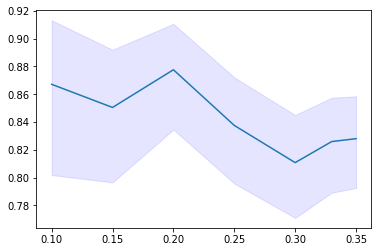

In [29]:
dicti = {'test_sizes': test_sizes, 'test_rows': test_rows, 'accuracies': accuracies, 'confint_lower': confint_lower, 
         'confint_upper': confint_upper, 'dif_confint': dif_confint, 'fit_time': fit_time} 
df = pd.DataFrame(dicti)
print(df[['test_sizes', 'accuracies', 'dif_confint', 'fit_time']])

fig, ax = plt.subplots()
ax.plot(test_sizes, accuracies)
ax.fill_between(test_sizes, confint_lower, confint_upper, color='b', alpha=.1)
fig.show()

Based on the previous results we decided to select a test size of 20%, because it has the highest accuracy (0.877622) and an acceptable confidence interval that is somehow narrow enough (width=0.076119) compared with the others.

In [30]:
# Final dataset partition with the chosen test size (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = nia)

### 3. Inner evaluation of basic metods (using default hyper-parameters)

Using default hyper-parameters, we will do an inner evaluation for the following basic methods: Dummy, Decisiontree and KNN. We will compute the accuracy of the 3-fold crossvalidation.

In [31]:
# KFold = 3
cv = KFold(n_splits=3, shuffle=True, random_state=nia)

#### a. Dummy classifier

In [32]:
# Defining the classifier
classifier_dummy = DummyClassifier(strategy='stratified', random_state= nia)

# Defining the pipeline
clf_dummy = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', classifier_dummy)])

clf_dummy

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'N...
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('classifier',
                 DummyClassifier(random_state=100435291,
                                 strategy='stratified'))])

The dummy classifier, using the stratified strategy, randomly samples from a multinomial distribution parametrized with the empirical class prior probabilities that are: Yes: 50.26% and No: 49.74%.

In [33]:
print(f'Probability of Yes: {round(sum(y_train)/y_train.shape[0]*100,2)}')
print(f'Probability of No: {round((y_train.shape[0]-sum(y_train))/y_train.shape[0]*100,2)}')

Probability of Yes: 50.26
Probability of No: 49.74


The mean accuracy of the dummy classifier in the inner evaluation is 0.51 with an statard deviation of 0.01. This accuracy will be a baseline for more advanced methods. It took 0.0979 seconds to run the fitting and cross validation.

In [34]:
# Accuracy of dummy classifier
time_start = time()
scores_dummy = cross_val_score(clf_dummy, X_train, y_train, scoring='accuracy', cv = cv) 
time_end = time()
time_scores_dummy = time_end-time_start

print(f"All the accuracies are: {scores_dummy}")
print(f"And the average crossvalidation accuracy is: {scores_dummy.mean():.2f} +- {scores_dummy.std():.2f}")
print(f'Time spent in the cross validation scoring: {round(time_scores_dummy, 4)} s')

All the accuracies are: [0.51842105 0.51842105 0.49210526]
And the average crossvalidation accuracy is: 0.51 +- 0.01
Time spent in the cross validation scoring: 0.0979 s


#### b. Tree model

In [35]:
# Defining the classifier
classifier_tree = tree.DecisionTreeClassifier(random_state=nia)

# Defining the pipeline
clf_tree = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', classifier_tree)])

clf_tree

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'N...
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('classifier', DecisionTreeClassifier(random_state=100435291))])

The mean accuracy of the Decision tree classifier, using the default hyperparameters, in the inner evaluation is 0.77 with a standard deviation of 0.04. This accuracy is significative higher than the dummy classifier.  It took 0.1084 seconds to run the fitting and cross validation.



In [36]:
# Accuracy of tree classifier
time_start = time()
scores_tree = cross_val_score(clf_tree, X_train, y_train, scoring='accuracy', cv = cv) 
time_end = time()
time_scores_tree = time_end-time_start

print(f"All the accuracies are: {scores_tree}")
print(f"And the average crossvalidation accuracy is: {scores_tree.mean():.2f} +- {scores_tree.std():.2f}")
print(f'Time spent in the cross validation scoring: {round(time_scores_tree, 4)} s')

All the accuracies are: [0.73157895 0.81842105 0.76842105]
And the average crossvalidation accuracy is: 0.77 +- 0.04
Time spent in the cross validation scoring: 0.1084 s


#### c. K-Nearest Neighbors

In [37]:
# Defining the classifier
classifier_knn = KNeighborsClassifier()

# Defining the pipeline
clf_knn = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier_knn)])

clf_knn

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'N...
                                                   'YearsAtCompany',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('classifier', KNeighborsClassifier())])

The mean accuracy of the KNN classifier, using the default hyperparameters, in the inner evaluation is 0.67 with a standard deviation of 0.02. This accuracy is higher than the dummy classifier but lower than the decision tree (with default hyperparameters). It took 0.1881 seconds to run the fitting and cross validation.

In [39]:
# Accuracy of knn classifier
time_start = time()
scores_knn = cross_val_score(clf_knn, X_train, y_train, scoring='accuracy', cv = cv) 
time_end = time()
time_scores_knn = time_end-time_start

print(f"All the accuracies are: {scores_knn}")
print(f"And the average crossvalidation accuracy is: {scores_knn.mean():.2f} +- {scores_knn.std():.2f}")
print(f'Time spent in the cross validation scoring: {round(time_scores_knn, 4)} s')

All the accuracies are: [0.68947368 0.64473684 0.67105263]
And the average crossvalidation accuracy is: 0.67 +- 0.02
Time spent in the cross validation scoring: 0.1881 s


### 4. Hyper-parameter tuning for the basic methods: KNN and trees

In this section we evaluate some models using methods for Hyperparameter Optimization (HPO). Notice that for our methods we are not going to be using the value *n_jobs = -1* which makes the operation more time efficient by parallel executing it in every CPU of the machine, so in this case the default will be doing only serial execution. We will review every execution time having in mind that these operations could be faster with better machines.

#### a. Grid Search for KNN

The hyperparameters that we tunned were *n_neighbors* and *p_distance*. We noticed that when tunning hyperparameters the default ones sometimes were better, meaning that for example higher accuracy levels were obtained with the default *p_distance* hyperparameter, that is euclidean.

For *n_neighbors* (the number of nearest neighbors), we started with a range from 1 to 40, but then we realized that we were obtaining higher accuracy levels for fewer neighbors. Actually, the best score is obtained when this hyperparameter is equal to one.

**Note**: For a previous analysis we had chosen *weights* as a hyperparameter, however it was not very useful given that we always got 'uniform' as the best result and this is in fact the default case. So we decided to leave the parameter out of the study for it to be more efficient. 

In [41]:
# Defining the classifier
classifier_knn = KNeighborsClassifier()

# Defining the pipeline
clf_knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', classifier_knn)])

# List Hyperparameters that we want to tune.
n_neighbors = list(range(1, 11))      # Default=5
p_distance = [1,2]                    # When p = 1 manhattan_distance and p = 2 is euclidean_distance. Default=2 (euclidean)
# weights = ['uniform', 'distance']   # Default=uniform
param_grid_knn = dict(classifier__n_neighbors = n_neighbors, 
                      classifier__p = p_distance)


# Defining the Grid search
grid_knn = GridSearchCV(clf_knn_pipeline,
                        param_grid_knn,
                        scoring = 'accuracy',
                        cv = cv,
                        verbose=1)

print('Model fitting...')
time_start = time()
np.random.seed(nia)
grid_knn_fit = grid_knn.fit(X_train, y_train)
time_end = time()
time_grid_knn = time_end-time_start
print('')
print(f'Time spent: {round(time_grid_knn, 4)} s')

Model fitting...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Time spent: 3.4337 s


With the best hyperparameters obtained from the grid search, we obtained an accuracy of 0.81, which is higher than using the default hyperparameters: 0.67. As we have seen this is due to change from using the five nearest neighbors in the fit to just the nearest neighbor.

In [42]:
# Best parameters from the grid
print(grid_knn_fit.best_params_, grid_knn_fit.best_score_)
inner_eval_knn = grid_knn_fit.best_score_
inner_eval_knn

{'classifier__n_neighbors': 1, 'classifier__p': 2} 0.8192982456140351


0.8192982456140351

In the following table we can see the accuracy is getting lower while increasing the number of neighbors in the fit. Also, the accuracy is higher when using the euclidean distance.

In [43]:
#  Dataframe with results from grid search
grid_knn_cv_results = pd.DataFrame(grid_knn.cv_results_)

# Pivot table from dataframe with rows as distance p and columns as number of neighbors
grid_knn_cv_results_pivot = pd.pivot_table(grid_knn_cv_results, values='mean_test_score',
                                           columns='param_classifier__n_neighbors',
                                           index='param_classifier__p',
                                           aggfunc=np.mean)

# Plot of the grid
cm = sns.color_palette("Blues", as_cmap=True) # try other palettes: "YlGnBu", "Blues", "BuPu" or "Greens"
display(grid_knn_cv_results_pivot.style.background_gradient(cmap=cm, axis=None))

param_classifier__n_neighbors,1,2,3,4,5,6,7,8,9,10
param_classifier__p,,,,,,,,,,
1,0.799123,0.736842,0.722807,0.693860,0.687719,0.673684,0.674561,0.677193,0.664035,0.668421
2,0.819298,0.728070,0.713158,0.685965,0.668421,0.672807,0.671930,0.667544,0.671930,0.662281


#### b. HPO methods for trees: Random Search, scikit-optimize, Optuna, Halving Random Search

##### Definition of the tree classifier

In [44]:
# Defining the classifier
classifier_tree = tree.DecisionTreeClassifier(random_state=nia)

# Defining the pipeline
clf_tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', classifier_tree)])
clf_tree_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'N...
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('classifier', DecisionTreeClassifier(random_state=100435291))])

##### b.1. Random Search

The hyperparameters that we tunned were *max_depth*, *min_samples_leaf*, *min_samples_split*, *criterion* and *splitter*. Once again we noticed that the default value for the hyperparameter *criterion* was good and, when using Random Search, the highest accuracy was obtained using the 'gini' criteria. The fit and inner validation took 4.56 seconds, with a budget of 50 that was increasing at the same we were reducing the range of the hyperparameters to get the samples of them.

In [45]:
# List Hyperparameters that we want to tune.
max_depth = [int(x) for x in np.linspace(10, 15, num = 6)]          # Default none
min_samples_leaf = [int(x) for x in np.linspace(1, 5, num = 5)]     # Default 1
min_samples_split = [int(x) for x in np.linspace(2, 6, num = 5)]    # Default 2
criterion = ["gini", "entropy"]                                     # Default gini
splitter = ["best", "random"]                                       # Default best

param_random_search_tree = dict(classifier__max_depth = max_depth, 
                             classifier__min_samples_leaf = min_samples_leaf,
                             classifier__min_samples_split = min_samples_split,
                             classifier__criterion = criterion,
                             classifier__splitter = splitter)

budget = 50

# Defining the Random Search
random_search_tree = RandomizedSearchCV(clf_tree_pipeline,
                                        param_random_search_tree,
                                        scoring = 'accuracy', #'accuracy' 'neg_mean_squared_error'
                                        cv = cv,
                                        verbose=1,
                                        n_iter = budget)

print('Model fitting...')
time_start = time()
np.random.seed(nia)
random_search_tree_fit = random_search_tree.fit(X_train, y_train)
time_end = time()
time_rs_tree = time_end - time_start
print('')
print(f'Time spent: {round(time_rs_tree, 4)} s')

Model fitting...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Time spent: 4.5653 s


In [46]:
# Best parameters from the random grid
print(random_search_tree_fit.best_params_, random_search_tree_fit.best_score_)
inner_eval_tree_rs = random_search_tree_fit.best_score_
inner_eval_tree_rs

{'classifier__splitter': 'random', 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 14, 'classifier__criterion': 'gini'} 0.7991228070175439


0.7991228070175439

In the following table there are each of the combinations fitted, it's order based on the best score in descending order.

In [47]:
# Dataframe with results from random search
random_search_tree_cv_results = pd.DataFrame(random_search_tree_fit.cv_results_)
random_search_tree_cv_results[['rank_test_score', 'param_classifier__min_samples_leaf', 'param_classifier__min_samples_split', 'param_classifier__max_depth',
                            'param_classifier__criterion', 'param_classifier__splitter', 'mean_test_score']].sort_values('rank_test_score').head()

,rank_test_score,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__max_depth,param_classifier__criterion,param_classifier__splitter,mean_test_score
41,1,1,3,14,gini,random,0.799123
37,2,1,4,14,gini,random,0.777193
13,3,1,2,15,gini,best,0.772807
5,4,1,5,11,gini,random,0.770175
9,5,1,3,12,entropy,best,0.769298


In this section we made several attempts with different ranges of the hyperparameters. For changing the ranges, we used the following table changing the rows and column for the different hyperparameter's values that were tunned. 

The purpose was to reduce the range to find the highest accuracy, while keeping the tree as simple as possible. The more we increased the *max_depth* range, the more we got similar accuracy values, so we decided not to try very high values since we were making the model more complex than necessary.

We noticed highest accuracies with *min_samples_leaf = 1* and lower accuracy values while this hyperparameter value increases. 

After testing with several ranges, we obtained a slightly higher accuracy 0.79 compared to 0.77 which was obtained when using the default hyperparameters.

In [48]:
# Pivot table from dataframe with rows as distance p and columns as number of neighbors
rgrid_tree_cv_results_pivot = pd.pivot_table(random_search_tree_cv_results, values='mean_test_score', 
                                columns='param_classifier__min_samples_split', 
                                index='param_classifier__min_samples_leaf', 
                                aggfunc=np.max)

# Plot of the grid
cm = sns.color_palette("Blues", as_cmap=True) 
display(rgrid_tree_cv_results_pivot.style.background_gradient(cmap=cm, axis=None))

param_classifier__min_samples_split,2,3,4,5,6
param_classifier__min_samples_leaf,,,,,
1,0.772807,0.799123,0.777193,0.770175,0.754386
2,0.753509,0.743860,0.742982,0.740351,0.732456
3,0.750000,0.739474,0.727193,0.727193,0.752632
4,0.747368,0.721930,0.750000,0.750000,0.747368
5,nan,0.748246,0.718421,0.721930,0.721930


 ##### b.2. Scikit-optimize

We tuned the same five hyperparameters. Once again we noticed that the default value for the hyperparameter criterion was good and, when using Scikit-optimize the highest accuracy was obtained using the 'gini' criteria. The fit and inner validation took 74.8 seconds, with a budget of 40 that was increasing at the same we were reducing the range of the hyperparameters to get the samples of them.

In [49]:
# List Hyperparameters that we want to tune.
max_depth = Integer(10,20)                      # Default None
min_samples_leaf = Integer(1,10)                # Default 1
min_samples_split = Integer(2,10)               # Default 2
criterion = Categorical(["gini", "entropy"])    # Default Gini
splitter = Categorical(["best", "random"])      # Default Best

param_optimize_tree = dict(classifier__max_depth = max_depth,
                           classifier__min_samples_leaf = min_samples_leaf,
                           classifier__min_samples_split = min_samples_split,
                           classifier__criterion = criterion,
                           classifier__splitter = splitter)

budget = 40

# Defining the Bayesian Search
scikitopt_tree = BayesSearchCV(clf_tree_pipeline,
                              param_optimize_tree,
                              scoring = 'accuracy',
                              cv = cv,
                              verbose=1,
                              n_iter=budget)

print('Model fitting...')
time_start= time()
np.random.seed(nia)
scikitopt_tree_fit = scikitopt_tree.fit(X_train, y_train)
time_end = time()
time_so_tree = time_end-time_start
print('')
print(f'Time spent: {round(time_so_tree, 4)} s')

Model fitting...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidate

We obtained a pretty similar accuracy (0.79) that when tunning the hyperparameters using the random search methodology. Most of the hyperparameters used in the fit with the best score are the same: criterion: 'gini', splitter: 'random' and min_samples_leaf: 1. The other hyperparameters have a slight change: max_depth was 14 in random search and in scikit optimize is 20, and min_samples_split was 3 in random search and in scikit optimize is 3.



In [50]:
# Best parameters from the grid
print(scikitopt_tree_fit.best_params_, scikitopt_tree_fit.best_score_)
inner_eval_tree_so = scikitopt_tree_fit.best_score_
inner_eval_tree_so

OrderedDict([('classifier__criterion', 'gini'), ('classifier__max_depth', 20), ('classifier__min_samples_leaf', 1), ('classifier__min_samples_split', 2), ('classifier__splitter', 'random')]) 0.793859649122807


0.793859649122807

We use the following plots from scikit optimize to make changes about the ranges of the hyperparameters. We can see clearly how we obtained better results for lower values of min_samples_leaf and it's an influencial hyperparameter.

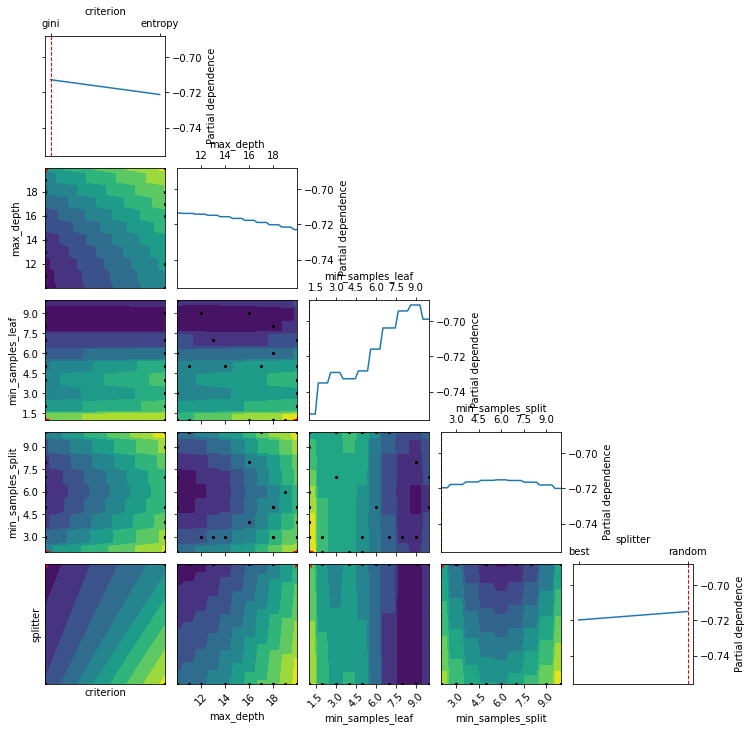

In [51]:
plot_objective(scikitopt_tree.optimizer_results_[0],
                   dimensions=["criterion", "max_depth", "min_samples_leaf", "min_samples_split", "splitter"],
                   n_minimum_search=int(1e8))
plt.show()

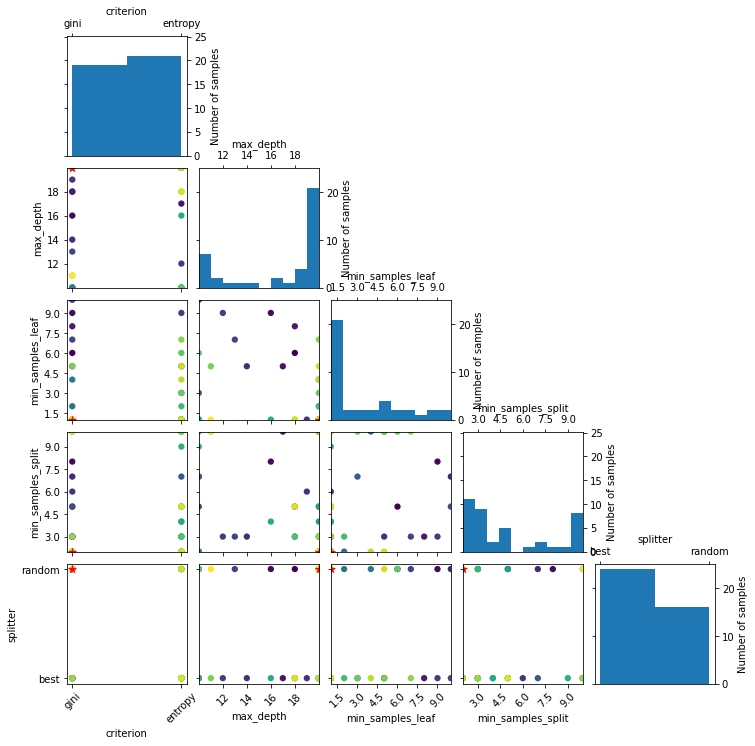

In [52]:
plot_evaluations(scikitopt_tree.optimizer_results_[0],
                 bins=10,
                 dimensions=["criterion", "max_depth", "min_samples_leaf", "min_samples_split", "splitter"])
plt.show()

Following the plot we observe that the hyperparameters *min_samples_split* and *criterion* barely affect our accuracy while making the model more complicated and time-consuming. We can make another study without these hyperparameters, meaning that they will stay at default value:

Model fitting...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidate

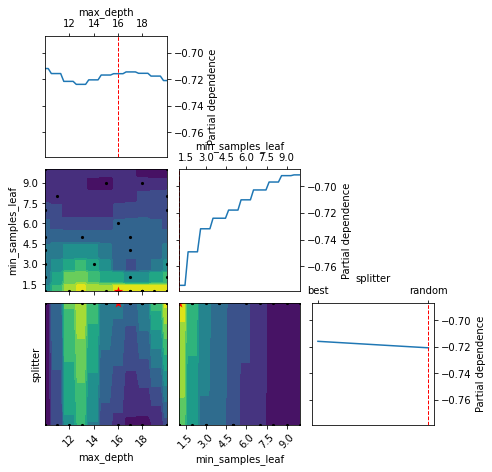

In [53]:
param_optimize_tree_simple = dict(classifier__max_depth = max_depth,
                                  classifier__min_samples_leaf = min_samples_leaf,
                                  classifier__splitter = splitter)

budget = 40

# Defining the Bayesian Search
scikitopt_tree_simple = BayesSearchCV(clf_tree_pipeline,
                                      param_optimize_tree_simple,
                                      scoring = 'accuracy',
                                      cv = cv,
                                      verbose=1,
                                      n_iter=budget)

print('Model fitting...')
time_start= time()
np.random.seed(nia)
scikitopt_tree_s_fit = scikitopt_tree_simple.fit(X_train, y_train)
time_end = time()
time_so_tree_s = time_end-time_start
print('')
print(f'Time spent: {round(time_so_tree_s, 4)} s')

# Best parameters from the grid
print(scikitopt_tree_s_fit.best_params_, scikitopt_tree_s_fit.best_score_)
inner_eval_tree_so_s = scikitopt_tree_s_fit.best_score_

plot_objective(scikitopt_tree_simple.optimizer_results_[0],
               dimensions=["max_depth", "min_samples_leaf", "splitter"],
               n_minimum_search=int(1e8))
plt.show()

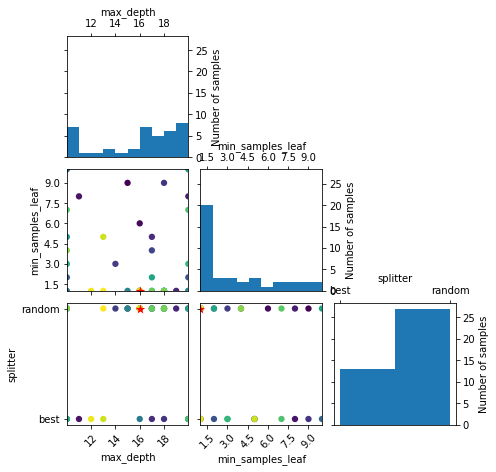

In [54]:
plot_evaluations(scikitopt_tree_simple.optimizer_results_[0],
                 bins=10,
                 dimensions=["max_depth", "min_samples_leaf", "splitter"])
plt.show()

After this change in the tunning, we obtain an accuracy of 0.7991, using the hyperparameters obtained from scikit optimize approach.

 ##### b.3. Optuna

In [82]:
def objective_optuna(trial):
    
    # Range of hyperparameters
    max_depth         = trial.suggest_int("max_depth", 10, 25)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf  = trial.suggest_int("min_samples_leaf", 1, 4)
    criterion         = trial.suggest_categorical("criterion", ["gini", "entropy"])
    splitter          = trial.suggest_categorical("splitter", ["best", "random"])
    
    # Defining the classifier
    classifier_tree = tree.DecisionTreeClassifier(max_depth = max_depth,
                                                  min_samples_split = min_samples_split,
                                                  min_samples_leaf = min_samples_leaf,
                                                  criterion = criterion,
                                                  splitter = splitter,
                                                  random_state = nia)
    
    # Defining the pipeline
    clf_tree = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier_tree)])

    np.random.seed(nia)
    # Scores
    scores = cross_val_score(clf_tree, X_train, y_train, 
                             scoring='accuracy',
                             cv=cv,
                             verbose=1)
    
    inner_mse = scores.mean()
    
    return inner_mse

In [83]:
budget = 15
study = optuna.create_study(direction = "maximize")

print('Model fitting...')
time_start= time()
np.random.seed(nia)
study.optimize(objective_optuna, n_trials = budget)
time_end = time()
time_optuna_tree = time_end-time_start
print('')
print(f'Time spent: {round(time_optuna_tree, 4)} s')

[I 2022-12-29 19:27:44,468] A new study created in memory with name: no-name-595b80ab-3f22-4a5d-a037-b58ee327ded0
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2022-12-29 19:27:44,568] Trial 0 finished with value: 0.7403508771929824 and parameters: {'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'gini', 'splitter': 'best'}. Best is trial 0 with value: 0.7403508771929824.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2022-12-29 19:27:44,659] Trial 1 finished with value: 0.75 and parameters: {'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'gini', 'splitter': 'random'}. Best is trial 1 with value: 0.75.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model fitting...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2022-12-29 19:27:44,749] Trial 2 finished with value: 0.7324561403508771 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini', 'splitter': 'random'}. Best is trial 1 with value: 0.75.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2022-12-29 19:27:44,841] Trial 3 finished with value: 0.7289473684210526 and parameters: {'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'gini', 'splitter': 'best'}. Best is trial 1 with value: 0.75.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2022-12-29 19:27:44,930] Trial 4 finished with value: 0.7087719298245614 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 4, 'cr


Time spent: 1.5725 s


Using the optuna approach for tunning, we obtain a similar accuracy: 0.7877. We can see that some of the value change but similarly than with the scikit optimize approach, the min_samples_leaf value is set to 1 once again.


In [84]:
# Best parameters from the halving random grid
print(study.best_params, study.best_value)
inner_eval_tree_optuna = study.best_value
inner_eval_tree_optuna

{'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'splitter': 'best'} 0.781578947368421


0.781578947368421

We use the following plots to once again adjust the range of the hyperparamters and also to adjust the number of trials. From the following graph we noticed that we can reduce the range of min_samples_leaf as it was always selecting 1 and the objective value (Accuracy) was highers for lower values in the hyperparameter. 

In [85]:
plot_parallel_coordinate(study)

In [87]:
plot_contour(study)

In [86]:
plot_optimization_history(study)

 ##### b.4. Halving Random Search

In [108]:
# List Hyperparameters that we want to tune.
np.random.seed(nia)
max_depth = [int(x) for x in np.linspace(14, 25, num = 11)]          # Default None
min_samples_leaf = [int(x) for x in np.linspace(1, 3, num = 4)]      # Default 1
min_samples_split = [int(x) for x in np.linspace(2, 8, num = 7)]     # Default 2
criterion = ["gini", "entropy"]                                      # Default Gini
splitter = ["best", "random"]                                        # Default Best

param_randomgrid_tree = dict(classifier__max_depth = max_depth, 
                             classifier__min_samples_leaf = min_samples_leaf,
                             classifier__min_samples_split = min_samples_split,
                             classifier__criterion = criterion,
                             classifier__splitter = splitter)

# Defining the random search
hrandomgrid_tree = HalvingRandomSearchCV(clf_tree_pipeline,
                                         param_randomgrid_tree,
                                         scoring = 'accuracy',
                                         cv = cv,
                                         verbose=1)

print('Model fitting...')
time_start = time()
np.random.seed(nia)
hrandomgrid_tree_fit = hrandomgrid_tree.fit(X_train, y_train)
time_end = time()
time_hrs_tree = time_end-time_start
print('')
print(f'Time spent: {round(time_hrs_tree, 4)} s')

Model fitting...
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 12
max_resources_: 1140
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 95
n_resources: 12
Fitting 3 folds for each of 95 candidates, totalling 285 fits
----------
iter: 1
n_candidates: 32
n_resources: 36
Fitting 3 folds for each of 32 candidates, totalling 96 fits
----------
iter: 2
n_candidates: 11
n_resources: 108
Fitting 3 folds for each of 11 candidates, totalling 33 fits
----------
iter: 3
n_candidates: 4
n_resources: 324
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 972
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Time spent: 11.3681 s


Using this method we are obtaining the lowest accuracy (0.76). We tried different factor values in the factor argument in HalvingRandomSearchCV. We obtained again the min_samples_leaf as 1.

In [109]:
# Best parameters from the halving random grid
print(hrandomgrid_tree_fit.best_params_, hrandomgrid_tree_fit.best_score_)
inner_eval_tree_hrs = hrandomgrid_tree_fit.best_score_
inner_eval_tree_hrs

{'classifier__splitter': 'random', 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 23, 'classifier__criterion': 'entropy'} 0.7633744855967078


0.7633744855967078

#### c. Summary of the HPO

In [110]:
# Methods
methods = ['KNN - No HPO',
           'KNN - Grid Search',
           'Tree - No HPO',
           'Tree - Random Search',
           'Tree - Scikit Optimize (Complete)',
           'Tree - Scikit Optimize (Simple)',
           'Tree - Optuna',
           'Tree - Halving Random Search']
# Accuracies obtained
accuracies = [scores_knn.mean(), inner_eval_knn,
                  scores_tree.mean(), inner_eval_tree_rs, inner_eval_tree_so, inner_eval_tree_so_s, 
                  inner_eval_tree_optuna, inner_eval_tree_hrs]
# Times
times = [time_scores_knn, time_grid_knn,
             time_scores_tree, time_rs_tree, time_so_tree, time_so_tree_s, 
             time_optuna_tree, time_hrs_tree]

The following table and plots show the accuracies obtained in the previous methos using default or HPO methodology. Also, there are the times of the fitting and cross validation process for each one.

We obtained a highest accuracy (0.819) using the KNN method and with the parameters obtained from the grid search, compared with the lowest accuracy (0.66) that was obtained fitting KNN but with default hyperparameters.

The hyperparameters tunning approaches that took more time were Scikit optimize (more than one minute) and Halving random search (approx. 11 seconds).

In [121]:
summary_4c = pd.DataFrame({'methods': methods, 'accuracies': accuracies, 'times': times}).sort_values('accuracies', ascending=False)

cm = sns.color_palette("Blues", as_cmap=True) 
display(summary_4c.style.background_gradient(cmap=cm, axis=0))

,methods,accuracies,times
1,KNN - Grid Search,0.819298,3.433677
3,Tree - Random Search,0.799123,4.565289
5,Tree - Scikit Optimize (Simple),0.799123,68.154346
4,Tree - Scikit Optimize (Complete),0.793860,74.828900
6,Tree - Optuna,0.781579,1.572481
2,Tree - No HPO,0.772807,0.108404
7,Tree - Halving Random Search,0.763374,11.368088
0,KNN - No HPO,0.668421,0.188068


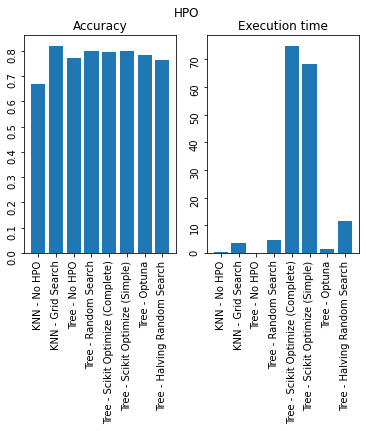

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('HPO')

ax1.title.set_text('Accuracy')
ax1.bar(methods, accuracies)
ax1.tick_params(labelrotation=90)

ax2.title.set_text('Execution time')
ax2.bar(methods, times)
ax2.tick_params(labelrotation=90)

### 5. Advanced methods

#### a. Random Forests: Comparison with default hyperparameters and HPO: Halving Random Search

##### a.1 Default hyperparameters

We chose the random forest method, the mean accuracy using the default hyperparameters, in the inner evaluation is 0.86 with an statard deviation of 0.02. This accuracy is higher than the previous fitted methods. Fitting this method doesn't take too long (approx. 1.7 s)

In [122]:
# Default hyperparameters

# Defining the classifier
classifier_rf = RandomForestClassifier(random_state= nia)

# Defining the pipeline
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', classifier_rf)])

clf_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'N...
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('classifier', RandomForestClassifier(random_state=100435291))])

In [123]:
# Accuracy of Random Forest classifier
time_start = time()
scores_rf = cross_val_score(clf_rf, X_train, y_train, scoring='accuracy', cv = cv) 
time_end = time()
time_scores_rf = time_end-time_start

print(f"All the accuracies are: {scores_rf}")
print(f"And the average crossvalidation accuracy is: {scores_rf.mean():.2f} +- {scores_rf.std():.2f}")
print(f'Time spent in the cross validation scoring: {round(time_scores_rf, 4)} s')

All the accuracies are: [0.87631579 0.86315789 0.83684211]
And the average crossvalidation accuracy is: 0.86 +- 0.02
Time spent in the cross validation scoring: 1.7214 s


##### a.2 HPO: Halving Random Search

In [129]:
# HPO Hyperparameter tuning of Random Forest

# List Hyperparameters that we want to tune.
max_depth = [int(x) for x in np.linspace(10, 20, num = 5)]           # Default None
min_samples_split = [int(x) for x in np.linspace(2, 10, num = 5)]    # Default 2
min_samples_leaf = [int(x) for x in np.linspace(1, 10, num = 5)]     # Default 1
n_estimators = [50, 100, 150, 200]                                   # Default 100
criterion = ['gini', 'entropy']                                      # Default Gini

param_randomgrid_rf = dict(classifier__max_depth = max_depth, 
                           classifier__min_samples_leaf = min_samples_leaf,
                           classifier__min_samples_split = min_samples_split,
                           classifier__n_estimators = n_estimators,
                           classifier__criterion = criterion)

# Defining the random search
hrandomgrid_rf = HalvingRandomSearchCV(clf_rf,
                                       param_randomgrid_rf,
                                       scoring = 'accuracy',
                                       cv = cv,
                                       verbose=1)

print('Model fitting...')
time_start = time()
np.random.seed(nia)
hrandomgrid_rf_fit = hrandomgrid_rf.fit(X_train, y_train)
time_end = time()
time_rf_hpo = time_end-time_start
print('')
print(f'Time spent in the cross validation: {round(time_rf_hpo, 4)} s')

Model fitting...
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 12
max_resources_: 1140
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 95
n_resources: 12
Fitting 3 folds for each of 95 candidates, totalling 285 fits
----------
iter: 1
n_candidates: 32
n_resources: 36
Fitting 3 folds for each of 32 candidates, totalling 96 fits
----------
iter: 2
n_candidates: 11
n_resources: 108
Fitting 3 folds for each of 11 candidates, totalling 33 fits
----------
iter: 3
n_candidates: 4
n_resources: 324
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 972
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Time spent in the cross validation: 106.3924 s


We obtained a lower accuracy while tunning the hyperparameters with the Halving Random Search approach, even when increasing the number of trees in the forest. We consider that the default value of 100 for the n_estimator hyperparameter is good enoguh to get an accuracy of 0.86.

In [131]:
# Best parameters from the grid
print(hrandomgrid_rf_fit.best_params_, hrandomgrid_rf_fit.best_score_)
inner_eval_rf = hrandomgrid_rf_fit.best_score_
inner_eval_rf

{'classifier__n_estimators': 150, 'classifier__min_samples_split': 8, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 12, 'classifier__criterion': 'gini'} 0.8353909465020576


0.8353909465020576

#### b. Gradient Boosting and HPO: Optuna

Gradient Boosting automatically imputes missing data, therefore it is not necessary to include an imputer in the pipeline at the transformation of the columns.

##### b.1 Default hyperparameters

In [132]:
# Default hyperparameters

# Defining the categorical transformer
categorical_transformer_hgb = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))]) 

# Defining the numerical transformer
numerical_transformer_hgb = Pipeline(steps = [('scale', StandardScaler())])

# Defining the preprocessor
preprocessor_hgb = ColumnTransformer(transformers=[('numerical', numerical_transformer_hgb, numerical_features),
                                               ('categorical', categorical_transformer_hgb, categorical_features)])

# Defining the classifier
classifier_hgb = HistGradientBoostingClassifier(random_state= nia)

# Defining the pipeline
clf_hgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier_hgb)])

clf_hgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'N...
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('classifier',
                 HistGradientBoostingClassifier(random_state=100435291))])

The mean accuracy using the default hyperparameters, in the inner evaluation is 0.83 with a standard deviation of 0.02.

In [133]:
# Accuracy of HistGradientBoosting classifier
time_start = time()
scores_hgb = cross_val_score(clf_hgb, X_train, y_train, scoring='accuracy', cv = cv)
time_end = time()
time_scores_hgb = time_end-time_start

print(f"All the accuracies are: {scores_hgb}")
print(f"And the average crossvalidation accuracy is: {scores_hgb.mean():.2f} +- {scores_hgb.std():.2f}")
print(f'Time spent in the cross validation scoring: {round(time_scores_hgb, 4)} s')

All the accuracies are: [0.84210526 0.85       0.79736842]
And the average crossvalidation accuracy is: 0.83 +- 0.02
Time spent in the cross validation scoring: 2.1681 s


##### b.2 HPO: Optuna

We will use Optuna to tune the hyperparameters, using the pruning unpromising trials feature. This feature automatically stops unpromising trials at early stage and we can notice that when the trial appears as 'prunned' in the output.


In [137]:
def objective_optuna_pruning(trial):
    
    # Range of hyperparameters
    max_iter = trial.suggest_int("max_iter", 150, 250)#, step=10)             # Default 100
    learning_rate = trial.suggest_float("learning_rate", 0.1, 0.5)            # Default 0.1
    max_depth = trial.suggest_int("max_depth", 20, 40)#, step=2)              # Default None
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 10, 30)              # Default 31

    # Defining the classifier
    classifier_hgb = HistGradientBoostingClassifier(max_depth = max_depth,
                                                    max_iter = max_iter,
                                                    learning_rate = learning_rate,
                                                    max_leaf_nodes = max_leaf_nodes,
                                                    random_state = nia)
    
    # Defining the pipeline
    clf_hgb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', classifier_hgb)])

    for step in range(20):

        # Scores
        scores = cross_val_score(clf_hgb, X_train, y_train, 
                                 scoring='accuracy',
                                 cv=cv)#, verbose=1)
        
        inner_mse = scores.mean()
        trial.report(inner_mse, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.TrialPruned(f"Trial was pruned at step {step}.")

    return inner_mse

In [138]:
# Set up the median stopping rule as the pruning condition.
budget = 10
study_pruning = optuna.create_study(pruner=optuna.pruners.MedianPruner(), direction = "maximize")

print('Model fitting...')
time_start= time()
np.random.seed(nia)
study_pruning.optimize(objective_optuna_pruning, n_trials = budget)
time_end = time()
time_hgb_optuna_prun = time_end-time_start
print('')
print(f'Time spent in the cross validation: {round(time_hgb_optuna_prun, 4)} s')

[I 2022-12-29 20:07:11,902] A new study created in memory with name: no-name-4e741c38-c6da-4f76-a1a1-b02913b6574d


Model fitting...


[I 2022-12-29 20:07:49,261] Trial 0 finished with value: 0.8543859649122808 and parameters: {'max_iter': 213, 'learning_rate': 0.22073367118351805, 'max_depth': 33, 'max_leaf_nodes': 15}. Best is trial 0 with value: 0.8543859649122808.
[I 2022-12-29 20:08:42,807] Trial 1 finished with value: 0.8552631578947368 and parameters: {'max_iter': 187, 'learning_rate': 0.2972413491395439, 'max_depth': 39, 'max_leaf_nodes': 24}. Best is trial 1 with value: 0.8552631578947368.
[I 2022-12-29 20:09:27,939] Trial 2 finished with value: 0.8421052631578947 and parameters: {'max_iter': 244, 'learning_rate': 0.10466841242878529, 'max_depth': 40, 'max_leaf_nodes': 13}. Best is trial 1 with value: 0.8552631578947368.
[I 2022-12-29 20:10:09,269] Trial 3 finished with value: 0.8482456140350877 and parameters: {'max_iter': 189, 'learning_rate': 0.4284950721728631, 'max_depth': 26, 'max_leaf_nodes': 25}. Best is trial 1 with value: 0.8552631578947368.
[I 2022-12-29 20:10:45,211] Trial 4 finished with value: 0


Time spent in the cross validation: 315.8985 s


In [139]:
# Best parameters from the halving random grid
print(study_pruning.best_params, study_pruning.best_value)
inner_eval_hgb_optuna = study_pruning.best_value
inner_eval_hgb_optuna

{'max_iter': 187, 'learning_rate': 0.2972413491395439, 'max_depth': 39, 'max_leaf_nodes': 24} 0.8552631578947368


0.8552631578947368

In [141]:
plot_optimization_history(study_pruning)

In [142]:
plot_parallel_coordinate(study_pruning)

In [143]:
plot_contour(study_pruning)

### 6. Results and final model

#### a. Report of results

In [159]:
# Models
summary_methods = ['Dummy - No HPO', 
                  'KNN - No HPO',
                  'KNN - Grid Search',
                  'Tree - No HPO',
                  'Tree - Random Search',
                  'Tree - Scikit Optimize (Complete)',
                  'Tree - Scikit Optimize (Simple)',
                  'Tree - Optuna',
                  'Tree - Halving Random Search',
                   'Random Forest - No HPO',
                   'Random Forest - Halving Random Search',
                   'Gradient Boosting - No HPO',
                   'Gradient Boosting - Optuna']

# Accuracies
summary_scores = [scores_dummy.mean(), scores_knn.mean(), inner_eval_knn, 
                  scores_tree.mean(), inner_eval_tree_rs, inner_eval_tree_so, inner_eval_tree_so_s,
                  inner_eval_tree_optuna, inner_eval_tree_hrs, 
                  scores_rf.mean(), inner_eval_rf, 
                  scores_hgb.mean(), inner_eval_hgb_optuna]

# Times
summary_times = [time_scores_dummy, time_scores_knn, time_grid_knn, 
                 time_scores_tree, time_rs_tree, time_so_tree, time_so_tree_s, 
                 time_optuna_tree, time_hrs_tree, 
                 time_scores_rf, time_rf_hpo, 
                 time_scores_hgb, time_hgb_optuna_prun]

In [163]:
summary = pd.DataFrame({'method': summary_methods, 'score': summary_scores, 'time': summary_times})
#summary.sort_values('score', ascending=False)

cm = sns.color_palette("Blues", as_cmap=True) 
display(summary.style.background_gradient(cmap=cm, axis=0))

,method,score,time
0,Dummy - No HPO,0.509649,0.097861
1,KNN - No HPO,0.668421,0.188068
2,KNN - Grid Search,0.819298,3.433677
3,Tree - No HPO,0.772807,0.108404
4,Tree - Random Search,0.799123,4.565289
5,Tree - Scikit Optimize (Complete),0.793860,74.828900
6,Tree - Scikit Optimize (Simple),0.799123,68.154346
7,Tree - Optuna,0.781579,1.572481
8,Tree - Halving Random Search,0.763374,11.368088
9,Random Forest - No HPO,0.858772,1.721415


#### b. Using the best method: Estimation of the accuracy (on the test set, outer evaluation) and a confidence interval for the accuracy

The best method is Random Forest, with an accuracy of 0.94 in the outer evaluation, that is evaluating the model in the other 20% test partition. We will compute the final model using all available data in c). The confidence interval for the accuracy is (0.91, 0.96).

In [152]:
# Best method: Random Forest (with Default Hyperparameters)
clf_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'N...
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('classifier', RandomForestClassifier(random_state=100435291))])

In [157]:
clf_final_model = clf_rf
clf_final_model.fit(X_train, y_train)

y_pred = clf_final_model.predict(X_test)
final_accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy estimation (outer evaluation): {round(final_accuracy, 4)}')

# Confidence interval for the accuracy
nrow = y_test.shape[0]
ci = proportion_confint(nrow*final_accuracy, nrow, method='wilson')
print(f'Confidence Interval for accuracy: {[round(ci[i], 4) for i in range(2)]}')

Accuracy estimation (outer evaluation): 0.9441
Confidence Interval for accuracy: [0.9111, 0.9653]


#### c. Training the final model with the best method and making predictions on the competition dataset. Saving the final model and the competition predictions on files.

We first compute the final model using all available data and make predictions on the *competition* dataset. 

In [154]:
# Train the final model
clf_final_model.fit(X, y)
# Saving the final model to a file
dump(clf_final_model, 'final_model.joblib')

['final_model.joblib']

In [155]:
# Predictions of final model on the competition dataset
y_finalmodel = pd.DataFrame(clf_final_model.predict(df_co))
# Saving the predictions of the final model to a pickle file
y_finalmodel.to_pickle("final_predictions.pkl")